In [111]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoLarsIC, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
X_art,y_art,X_dig,y_dig= eval_models.get_data()
X_dig_train,X_dig_test,y_dig_train,y_dig_test=train_test_split(X_dig,y_dig,stratify=y_dig,test_size=0.25)
X_art_train,X_art_test,y_art_train,y_art_test=train_test_split(X_art,y_art,stratify=y_art,test_size=0.25)

In [19]:
X_art_train_ss, X_art_test_ss = eval_models.standarize(X_art_train, X_art_test)

In [20]:
X_dig_train_ss, X_dig_test_ss = eval_models.standarize(X_dig_train, X_dig_test)

## 1. step - Lasso

In [123]:
def fit_lasso(X, y, **kwargs):
    lasso = LogisticRegression(**kwargs, )
    lasso.fit(X, y)
    return lasso

In [124]:
l = fit_lasso(X_art_train_ss, y_art_train, penalty='l1', solver='liblinear', C=0.05)

In [125]:
(l.coef_>0).sum()

70

## 2. step - nested families & BIC criterion

In [157]:
def calc_bic(y_true, y_pred, n_obs, n_col):
    return 100 * log_loss(y_true, y_pred) + np.log(n_obs) * n_col

def calc_aic(y_true, y_pred, n_obs, n_col):
    return 2 * log_loss(y_true, y_pred) + 2 * n_col

In [158]:
variables = []
rf = RandomForestClassifier()
results = pd.DataFrame(columns = ['step', 'train_scaled_bic', 'test_scaled_bic', 'train_bic', 'test_bic'])
n = len(X_art_train)
for step, v in enumerate(reversed(pd.Series(l.coef_.flatten())[l.coef_.flatten()>0].sort_values().index)):
    variables += [v]
    rf.fit(X_art_train_ss.loc[:, variables], y_art_train)
    y_pred_train_ss = rf.predict_proba(X_art_train_ss.iloc[:, variables])[:, 1]
    y_pred_test_ss = rf.predict_proba(X_art_test_ss.iloc[:, variables])[:, 1]
    
    rf.fit(X_art_train.loc[:, variables], y_art_train)
    y_pred_train = rf.predict_proba(X_art_train.iloc[:, variables])[:, 1]
    y_pred_test = rf.predict_proba(X_art_test.iloc[:, variables])[:, 1]
    
    new_results = pd.DataFrame([[step, 
                                 calc_bic(y_art_train, y_pred_train_ss, n, len(variables)),
                                 calc_bic(y_art_test, y_pred_test_ss, n, len(variables)),
                                 calc_bic(y_art_train, y_pred_train, n, len(variables)),
                                 calc_bic(y_art_test, y_pred_test, n, len(variables))]], columns=results.columns)
    print(log_loss(y_art_test, y_pred_test_ss))
    print(new_results)
    results = pd.concat((results, new_results))

1.090311932067758
   step  train_scaled_bic  test_scaled_bic  train_bic   test_bic
0     0         63.082203       116.344414  63.092416  98.174564
0.8023455526540324
   step  train_scaled_bic  test_scaled_bic  train_bic    test_bic
0     1         34.152225        94.860996  34.103055  101.354548
0.7510882578145475
   step  train_scaled_bic  test_scaled_bic  train_bic   test_bic
0     2         41.238386        97.048487  40.823555  98.178725
0.7172684399212629
   step  train_scaled_bic  test_scaled_bic  train_bic    test_bic
0     3         48.205802       100.979726  48.023309  101.949605
0.7037608698405845
   step  train_scaled_bic  test_scaled_bic  train_bic    test_bic
0     4         55.279481       106.942189  55.415006  106.767579
0.7026465291225227
   step  train_scaled_bic  test_scaled_bic  train_bic    test_bic
0     5         62.399519       114.143975  62.458858  113.152904
0.6968512016134801
   step  train_scaled_bic  test_scaled_bic  train_bic    test_bic
0     6       

0.6722705263273702
   step  train_scaled_bic  test_scaled_bic   train_bic    test_bic
0    54         421.52723       469.454174  421.446984  470.609546
0.6763440158616022
   step  train_scaled_bic  test_scaled_bic   train_bic    test_bic
0    55        428.833376       477.174743  428.743823  476.663489
0.6818787099500875
   step  train_scaled_bic  test_scaled_bic  train_bic    test_bic
0    56        436.329589       485.041433  435.96636  484.639569
0.666477449172811
   step  train_scaled_bic  test_scaled_bic   train_bic    test_bic
0    57        443.511971       490.814527  443.484059  491.306793
0.6760279163506628
   step  train_scaled_bic  test_scaled_bic   train_bic    test_bic
0    58        450.945433       499.082794  450.753715  498.551478
0.6821811290000026
   step  train_scaled_bic  test_scaled_bic   train_bic    test_bic
0    59        458.247196       507.011336  458.202411  506.271176
0.6839913603326049
   step  train_scaled_bic  test_scaled_bic   train_bic    test_bic

In [162]:
for step, v in enumerate(reversed(pd.Series(l.coef_.flatten())[l.coef_.flatten()>0].sort_values().index[-2:])):
    variables += [v]
    rf.fit(X_art_train_ss.loc[:, variables], y_art_train)
    y_pred_train_ss = rf.predict_proba(X_art_train_ss.iloc[:, variables])[:, 1]
    y_pred_test_ss = rf.predict_proba(X_art_test_ss.iloc[:, variables])[:, 1]

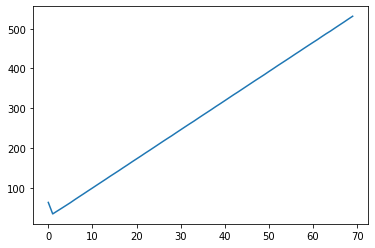

In [161]:
plt.plot(results['step'], results['train_scaled_bic'])

In [139]:
ex = X_dig.loc[0, :]

In [149]:
np.sqrt(4855)

69.67783004657937